In [3]:
import pickle
import pandas as pd
import multiprocessing as mp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from Bio import SeqIO
import os
import subprocess
import ast
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
from collections import Counter

In [2]:
import ete3
from ete3 import Tree

## Identify taxa of sister and cousin branches to faciltate manual tree inspection

In [3]:
from pathlib import Path

def find_parents_with_contree(root):
    """Return a sorted list of parent directories whose child contains
    an 'ml_tree.contree' file.
    """
    root = Path(root)            # <-- coerce str → Path
    parents: set[Path] = set()

    for child_dir in root.rglob("*"):
        if child_dir.is_dir() and (child_dir / "ml_tree.contree").is_file():
            parents.add(str(child_dir.resolve()).split("/")[-1])

    return sorted(str(p) for p in parents)
parents = find_parents_with_contree("outputs/phylogenetic_dataset")

In [4]:
### takes a datafraame row and returns an origin annotation 
def tax_label(row):
    x=row['lineage']
    if 'Fungi' in x:
        return 'Fungi'
    elif 'Viruses' in x:
        return 'Viruses'
    elif 'Bacteria' in x:
        return 'Bacteria'
    elif 'Viridiplantae' in x:
        return 'Viridiplantae'
    elif 'primary_chimera' in str(row):
        return 'Arthropoda'
    elif 'secondary' in row.index and row['secondary']==True:
        return 'Arthropoda'
    elif 'Arthropoda' in x:
        return 'Arthropoda'
    elif 'Rotifera' in x:
        return 'Rotifera'
    elif 'Metazoa' in x:
        return 'Metazoa' 
    elif 'Sar' in x:
        return 'Sar'
    elif 'Evosea' in x:
        return 'Evosea'
    elif 'Metamonada' in x:
        return x
    elif 'Archaea' in x:
        return 'Archaea'
    else:
        return x
        

In [5]:
"""
takes an hgt or metazoan interval in phylogenetic_dataset and returns the phylogenetic annotation of sister and cousin branches
"""
def get_sister_cousin(interv):
    ch=";".join(interv.split(";")[0:2])
    
    ##loads ete tree and dataframe with taxonomic information
    t=Tree(f'outputs/phylogenetic_dataset/{ch}/{interv}/edited_ml_tree.treefile.rooted')
    combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{interv}/combined_sequences_data.tsv',sep='\t')
    try:
        combined=combined.set_index('target_name')
    except:
        combined=combined.set_index('sseqid')

    ##make a mapping between sequence name and taxonomic label
    tax_map={}
    
    for index, row in combined.iterrows():
        if ';' in index:
            tax_map[index.split(";")[1]]=tax_label(row)
        else:
            tax_map[index]=tax_label(row)
            
    ##annotate the tree terminal nodes with taxnames
    for node in t:
        node.add_features(taxname=tax_map[node.name])
    
    ## extract focal hgt-chimera
    n=interv.split(";")[1]
    focal= t&n
    
    ## identify clades of non-arthropod sister cousins by iteratively getting closest neighbors
    s=False
    sister=[]
    cousin=[]
    pooled_sister_cousin=[]
    while True:
        if not focal.up:
            break
        ##sisters are all descendants of parent of focal except for focal's descendants
        sisters=set(focal.up.get_leaves())-set(focal.get_leaves())
    
        if len(set([x.taxname for x in sisters])-set(['Arthropoda']))>0:
            counts=dict(Counter([x.taxname for x in sisters if x.taxname!='Arthropoda']))
            pooled_sister_cousin.extend([x.taxname for x in sisters if x.taxname!='Arthropoda'])
            max_count=max(counts.values())
            
            ##sister if not already found, else cousin
            if not s:
                sister=[x for x in counts if counts[x]==max_count]
                s=True
            else:
                cousin=[x for x in counts if counts[x]==max_count]
                break
        if focal.up:
            focal=focal.up
        else:
            break
    ##identify donor taxon as most frequent among pooled sister/cousins
    counts=dict(Counter([x for x in pooled_sister_cousin if x!='Arthropoda']))   
    max_count=max(counts.values())
    donor=[x for x in counts if counts[x]==max_count]
    return str(sister), str(cousin), str(donor)

In [1]:
## add sister/cousin info to metazoan  df for manual inspection
df=pd.read_csv('all_Tree_manual_inspection_Metazoan.tsv',sep='\t',index_col=0)
for index, row in df.iterrows():
    df.loc[index,['sister', 'cousin','donor']]=get_sister_cousin(index)
df.to_csv('all_Tree_manual_inspection_Metazoan.tsv',sep='\t')

In [2]:
## add sister/cousin info to hgt df for manual inspection
df=pd.read_csv('all_Tree_manual_inspection_HGT.tsv',sep='\t',index_col=0)
for index, row in df.iterrows():
    df.loc[index,['sister', 'cousin','donor']]=get_sister_cousin(index)
df.to_csv('all_Tree_manual_inspection_HGT.tsv',sep='\t')

## Load and annotate final hgt/metazoan inspection trees

In [46]:
## load manual inspection results for HGT trees (note--only metazoan intervals from HGT-confirmed trees were inspected)

hgt=pd.read_csv("Tree_manual_inspection_HGT.tsv",sep='\t',index_col=0)
hgt=hgt[hgt.Tree_annot=='Yes']
hgt['gene']=[";".join(x.split(";")[0:2]) for x in hgt.index]

In [47]:
## load manual inspection results for metazoan trees (note--only metazoan intervals from HGT-confirmed trees were inspected)
meta=pd.read_csv("Tree_manual_inspection_MGT.tsv",sep='\t',index_col=0)
meta=meta[meta.Tree_annot=='Yes']
meta['gene']=[";".join(x.split(";")[0:2]) for x in meta.index]
## filter by those hgt intervals whose corresponding metazoan intervals have also been confirmed
hgt=hgt[hgt.gene.isin(meta.gene)]

In [48]:
hgt=hgt.loc[:,['span','Note','donor',
       'sister', 'cousin']]
hgt['donor']=[x.replace("[","").replace("]","").replace("'","") for x in hgt.donor]
hgt['sister']=[x.replace("[","").replace("]","").replace("'","") for x in hgt.sister]
hgt['cousin']=[x.replace("[","").replace("]","").replace("'","") for x in hgt.cousin]
hgt=hgt.loc[:,['span','Note','donor',
       'sister', 'cousin']]
hgt.columns=['span', 'tree_Note', 'tree_donor', 'tree_sister_kingdom', 'tree_cousin_kingdom']


In [49]:
##add blast data
hgt_df=pd.read_csv("outputs/round2_blast_statistics_hgt_intervals.tsv",sep="\t",index_col=0)
for index, row in hgt.iterrows():
    hgt.loc[index,['blast_min_evalue','blast_evalue_min_cov','blast_evalue_min_title','blast_evalue_min_sciname','blast_p_HGT300','blast_AI','blast_N_AI>5']]=list(hgt_df.loc[index,['min_evalue','evalue_min_cov','evalue_min_title','evalue_min_sciname','p_HGT300','AI','N_AI>5']])

In [23]:
blast_hits=[]
for x in hgt.index:
    chimera=";".join(x.split(";")[0:2])
    a2=SeqIO.to_dict(SeqIO.parse(f'outputs/hmmbuild/{chimera}/{x}/sub_seq.fasta', 'fasta'))
    if len(a2.keys())<=1:
        ##extract sequences that have only self blast-hits (bit-score>min(bit-score non-arthropod))
        ##blast hits instead of hmmsearch hits are used for phylogenetic dataset contstruction
        blast_hits.append(x)
hmmer_hits=set(hgt.index)-set(blast_hits)

In [32]:
## add hmmer data for intervals that use hmmer data
for interval in hmmer_hits:
    chimera=";".join(interval.split(";")[0:2])
    df=pd.read_csv(f"outputs/phylogenetic_dataset/{chimera}/{interval}/combined_sequences_data.tsv",sep="\t")
    df=df[~df['i-Evalue'].astype(str).str.contains('chimera')]
    df['i-Evalue']=df['i-Evalue'].astype(float)
    l=list(df[(df.phylum!='Arthropoda')&(df.phylum!='Rotifera')].sort_values('i-Evalue').iloc[0,:].loc[['target_name','description of target','species','lineage','i-Evalue']])
    hgt.loc[interval,['hmmer_seq','hmmer_description','hmmer_species','hmmer_lineage','hmmer_i-Evalue']]=l

In [52]:
from ete3 import NCBITaxa

def lineage_from_common(common_name,rank_filter=None) -> list[str]:
    """
    Return the complete taxonomic lineage (names, not TaxIDs) for a taxon
    specified by its common name.

    Parameters
    ----------
    common_name : str
        Vernacular name (case-insensitive) to resolve in the NCBI taxonomy.
    rank_filter : set[str] | None, optional
        If provided, keep only ranks whose lowercase names are in this set
        (e.g. {"phylum", "class", "order", "family", "genus", "species"}).

    Returns
    -------
    list[str]
        Ordered list of scientific names from root to the focal taxon.

    Raises
    ------
    ValueError
        If the common name cannot be uniquely mapped to a single TaxID.
    """
    ncbi = NCBITaxa()                       # uses cached SQLite DB in ~/.etetoolkit
    # Ensure database is present/updated once per session
    # ncbi.update_taxonomy_database()      # uncomment the first time you run this

    # Resolve vernacular → TaxID(s)
    name_to_taxid = ncbi.get_name_translator([common_name.lower()])
    if not name_to_taxid:
        raise ValueError(f"No match found in NCBI taxonomy for '{common_name}'.")
    if len(name_to_taxid[common_name.lower()]) > 1:
        raise ValueError(f"Common name '{common_name}' maps to multiple taxa: "
                         f"{name_to_taxid[common_name.lower()]}")

    taxid = name_to_taxid[common_name.lower()][0]

    # Get lineage as TaxIDs → convert to names
    lineage_taxids = ncbi.get_lineage(taxid)
    id_to_name = ncbi.get_taxid_translator(lineage_taxids)
    id_to_rank = ncbi.get_rank(lineage_taxids)

    lineage_names = [
        id_to_name[t]
        for t in lineage_taxids
        if rank_filter is None or id_to_rank[t].lower() in rank_filter
    ]
    return lineage_names


In [53]:
for index, row in hgt.iterrows():
    s=row['blast_evalue_min_sciname']
    if ";" in s:
        s=s.split(";")[1]
    hgt.loc[index,'blast_evalue_min_lineage']=str(lineage_from_common(s))

In [54]:
## returns taxonomic label from a lineage string 
def tax_label_blast_hmmer(x):
    if 'Fungi' in x:
        return 'Fungi'
    elif 'Viruses' in x:
        return 'Viruses'
    elif 'Bacteria' in x:
        return 'Bacteria'
    elif 'Viridiplantae' in x:
        return 'Viridiplantae'
    elif 'primary_chimera' in str(row):
        return 'Arthropoda'
    elif 'Arthropoda' in x:
        return 'Arthropoda'
    elif 'Rotifera' in x:
        return 'Rotifera'
    elif 'Metazoa' in x:
        return 'Metazoa' 
    elif 'Sar' in x:
        return 'Sar'
    elif 'Evosea' in x:
        return 'Evosea'
    elif 'Metamonada' in x:
        return x
    elif 'Archaea' in x:
        return 'Archaea'
    else:
        return x
        

In [55]:
for index, row in hgt.iterrows():
    l=row['blast_evalue_min_lineage']
    hgt.loc[index,'blast_evalue_min_kingdom']=tax_label_blast_hmmer(l)
    l=row['hmmer_lineage']
    if str(l)!='nan':
        hgt.loc[index,'hmmer_kingdom']=tax_label_blast_hmmer(l)

In [56]:
hgt=hgt.sort_values('blast_min_evalue')

In [57]:
## returns sister and cousin species for a given hgt/metazoan interval by inspecting the phylogeny
def get_sister_cousin(interv):
    ch=";".join(interv.split(";")[0:2])
    t=Tree(f'outputs/phylogenetic_dataset/{ch}/{interv}/edited_ml_tree.treefile.rooted')
    combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{interv}/combined_sequences_data.tsv',sep='\t')
    try:
        combined=combined.set_index('target_name')
    except:
        combined=combined.set_index('sseqid')
        
    tax_map={}
    for index, row in combined.iterrows():
        if ';' in index:
            tax_map[index.split(";")[1]]=tax_label(row)
        else:
            tax_map[index]=tax_label(row)
 
    for node in t:
        node.add_features(taxname=tax_map[node.name])
    

    for node in t:
        node.add_features(species=combined[combined.index.str.contains(node.name)]['species'].values[0])
    
    n=interv.split(";")[1]
    focal= t&n
    s=False
    sister=[]
    cousin=[]
    pooled_sister_cousin=[]
    while True:
        if not focal.up:
            break
        sisters=set(focal.up.get_leaves())-set(focal.get_leaves())
        
        if len(set([x.taxname for x in sisters])-set(['Arthropoda'])-set(['Metazoa']))>0:
            if not s:
                sister=[x.species for x in sisters if x.taxname!='Arthropoda' and x.taxname!='Metazoa']
                s=True
            else:
                cousin=[x.species for x in sisters if x.taxname!='Arthropoda' and x.taxname!='Metazoa']
                break
        if focal.up:
            focal=focal.up
        else:
            break
 
    return str(sister), str(cousin)

In [58]:
for index, row in hgt.iterrows():
    hgt.loc[index, ['sister_species','cousin_species']]=get_sister_cousin(index)

In [59]:
## tabulate occurances of possible symbionts in sister and cousin taxa
from collections import defaultdict
symbiomap=defaultdict(list)
## load genera of  arthropod sybionts  from sybiogenomesdb (access date 6/29/2025)
symbiodb=pd.read_csv("symbiogenomesdb.tsv",sep="\t")
symbiodb=symbiodb.loc[:,['name','node']]
symbiodb=symbiodb.set_index('name')
bacteria=hgt[hgt.tree_donor=='Bacteria']
interset=set()
for n, row in symbiodb.iterrows():
    inters=list(bacteria[bacteria.sister_species.str.contains(n)|bacteria.cousin_species.str.contains(n)].index)
    symbiodb.loc[n,'inters']=str(inters)
    symbiodb.loc[n,'n_inters']=len(inters)
    interset=interset|set(inters)
    for x in inters:
        symbiomap[x].append(n)
for inter in symbiomap:
    hgt.loc[inter,'symbiont_relatives']=str(symbiomap[inter])

In [110]:
len(interset)

37

In [60]:
sup4=pd.read_csv("SI tables/SI table 4.tsv",sep="\t",index_col='q_name')
for index, row in hgt.iterrows():
    ch=";".join(index.split(";")[0:2])
    hgt.loc[index,['cluster','species']]=list(sup4.loc[ch,['cluster_id','q_species']])

In [61]:
hgt=hgt.loc[:,['cluster', 'species','span', 'tree_Note', 'tree_donor', 'tree_sister_kingdom',
       'tree_cousin_kingdom', 'sister_species',
       'cousin_species', 'symbiont_relatives',
       'blast_evalue_min_title', 'blast_evalue_min_sciname','blast_evalue_min_kingdom','blast_min_evalue', 'blast_evalue_min_cov', 'blast_p_HGT300',
       'blast_AI', 'blast_N_AI>5', 'hmmer_seq','hmmer_description', 'hmmer_species',  'hmmer_kingdom', 'hmmer_i-Evalue']]

In [62]:
hgt.columns=['cluster_id', 'query_species', 'tax_span', 'tree_Note', 'tree_donor',
       'tree_sister_kingdom', 'tree_cousin_kingdom', 'sister_species',
       'cousin_species', 'symbiont_relatives', 'blast_seq',
       'blast_species', 'blast_tax_label',
       'blast_evalue', 'blast__cov', 'blast_p_HGT300',
       'blast_AI', 'blast_N_AI>5', 'hmmer_seq','hmmer_description', 'hmmer_species',
       'hmmer_kingdom', 'hmmer_i-Evalue']

In [ ]:
## correct an accidental inclusion of a synthetic blast hit for GCF_001856785.1;XP_022173178.1;HGT_(532,960)
record_dict=SeqIO.to_dict(SeqIO.parse('outputs/split_intervals.fasta', 'fasta'))
hgt_df=pd.read_csv("outputs/round2_blast_statistics_hgt_intervals.tsv",sep="\t",index_col=0)
n='GCF_001856785.1;XP_022173178.1;HGT_(532,960)'

df=pd.read_csv(f"outputs/round2_diamond_output_split/{n}.tsv",sep="\t")
leng=len(record_dict[n.split('.tsv')[0]].seq)
df["cov"]=(np.array(df.qend)-np.array(df.qstart)+1)/leng
#filter by >30% coverage of the query
dfo=df[df["cov"]>.30]
dfo=dfo[~dfo.sphylums.astype(str).str.contains("Arthropoda")]
dfo=dfo[~dfo.sphylums.astype(str).str.contains("Rotifera")]
dfo=dfo[dfo.staxids.astype(str)!="nan"]
##exclude synthetic sequences
dfm=dfo[dfo.staxids!=32630]

dfmeta=dfm[dfm.skingdoms.astype(str).str.contains("Metazoa")]
dfhgt=dfm[~dfm.skingdoms.astype(str).str.contains("Metazoa")]
dfhgt["AI"]=np.log10(dfmeta.evalue.min()+1e-200)-np.log10(dfhgt.evalue+1e-200)
dfmeta["MI"]=np.log10(dfhgt.evalue.min()+1e-200)-np.log10(dfmeta.evalue+1e-200)

##get the top 300 hits by lowest evalue
dfmi=dfm.iloc[0:300,:]
dfmetai=dfmi[dfmi.skingdoms.astype(str).str.contains("Metazoa")]
dfhgti=dfmi[~dfmi.skingdoms.astype(str).str.contains("Metazoa")]



dfhgt=dfhgt[dfhgt.sseqid!='BDA76956.1']
print(list(dfhgt.loc[dfhgt.bitscore.idxmax(),['bitscore']])+list(dfhgt.loc[dfhgt.evalue.idxmin(),['evalue', 'cov','stitle','sscinames','sphylums','skingdoms']])+[dfmeta.shape[0], len(set(dfhgt.staxids)),len(set(dfhgti.staxids))/len(set(dfmi.staxids)),dfhgt.AI.max(),len(set(dfhgt[dfhgt.AI>5].staxids))])
hgt.loc[n,['blast_seq', 'blast_species',
       'blast_tax_label', 'blast_evalue', 'blast__cov', 'blast_p_HGT300',
       'blast_AI', 'blast_N_AI>5']]=['RUS30064.1 phytoene synthase [Jimgerdemannia flammicorona]', 'Jimgerdemannia flammicorona','Fungi',6.07e-105,0.9888392857142857, 1,99.58972331189486,3089] 
    


In [34]:
##output table with combined blast and hmmer and phylogenetic evidence of hgt per hgt interval
hgt.to_csv('SI tables/SI table 7.tsv',sep='\t')


In [85]:
symbiodb=symbiodb.sort_values('n_inters',ascending=False)

In [86]:
## output table with symbiont data
symbiodb.to_csv('SI tables/SI table 8.tsv',sep='\t')

## Data Plotting 
Figure 2A-B

In [103]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager

from pathlib import Path

import matplotlib as mpl

from matplotlib.patches import Patch
from matplotlib.lines import Line2D



fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")


from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['svg.fonttype']='none'

In [104]:
from collections import Counter
l=dict(Counter(hgt.tree_donor))
l =  dict(sorted(l.items(), key=lambda kv: kv[1]))

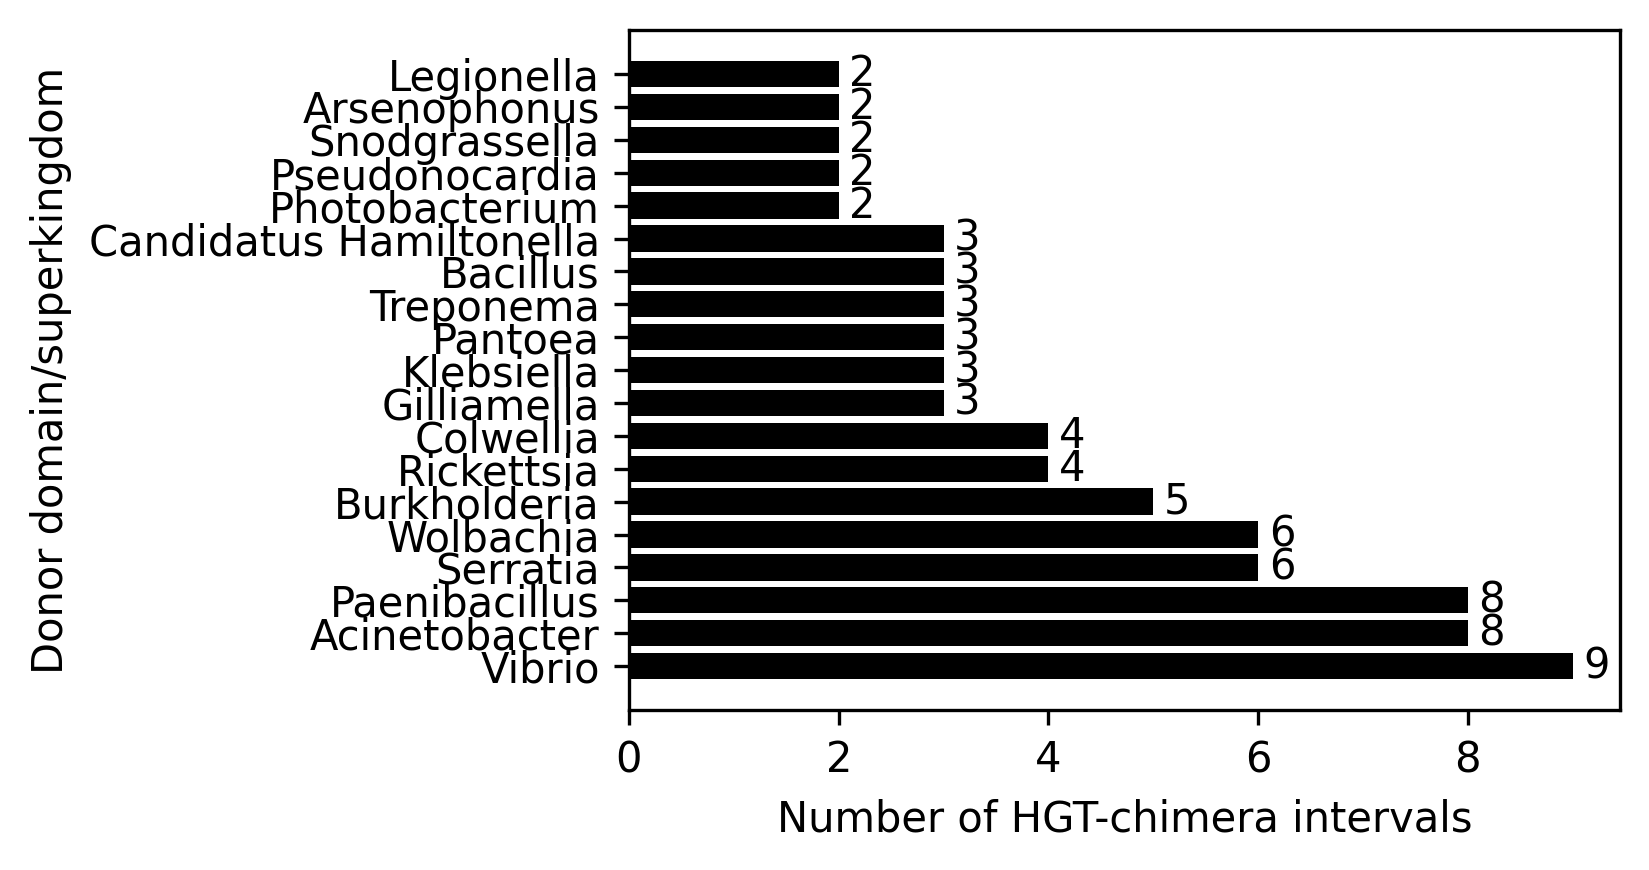

In [106]:
fig, ax = plt.subplots(figsize=(5.6, 3)) 

bars = ax.barh(
    list(l.keys()),   # y-positions / labels
    list(l.values()), # bar lengths
    color='black'
)

# Add a number at the end of every bar
for bar in bars:
    width = bar.get_width()                         # numeric value
    y_pos = bar.get_y() + bar.get_height() / 2      # bar’s vertical center
    ax.text(
        width + 0.1,                                # a small offset to the right
        y_pos,
        f'{width:.0f}',                             # format as integer
        va='center',
        ha='left'
    )

plt.xlabel('Number of HGT-chimera intervals')
plt.ylabel('Donor domain/superkingdom')
plt.tight_layout()
# plt.savefig('figures/SI figure 5A.svg',format='svg')

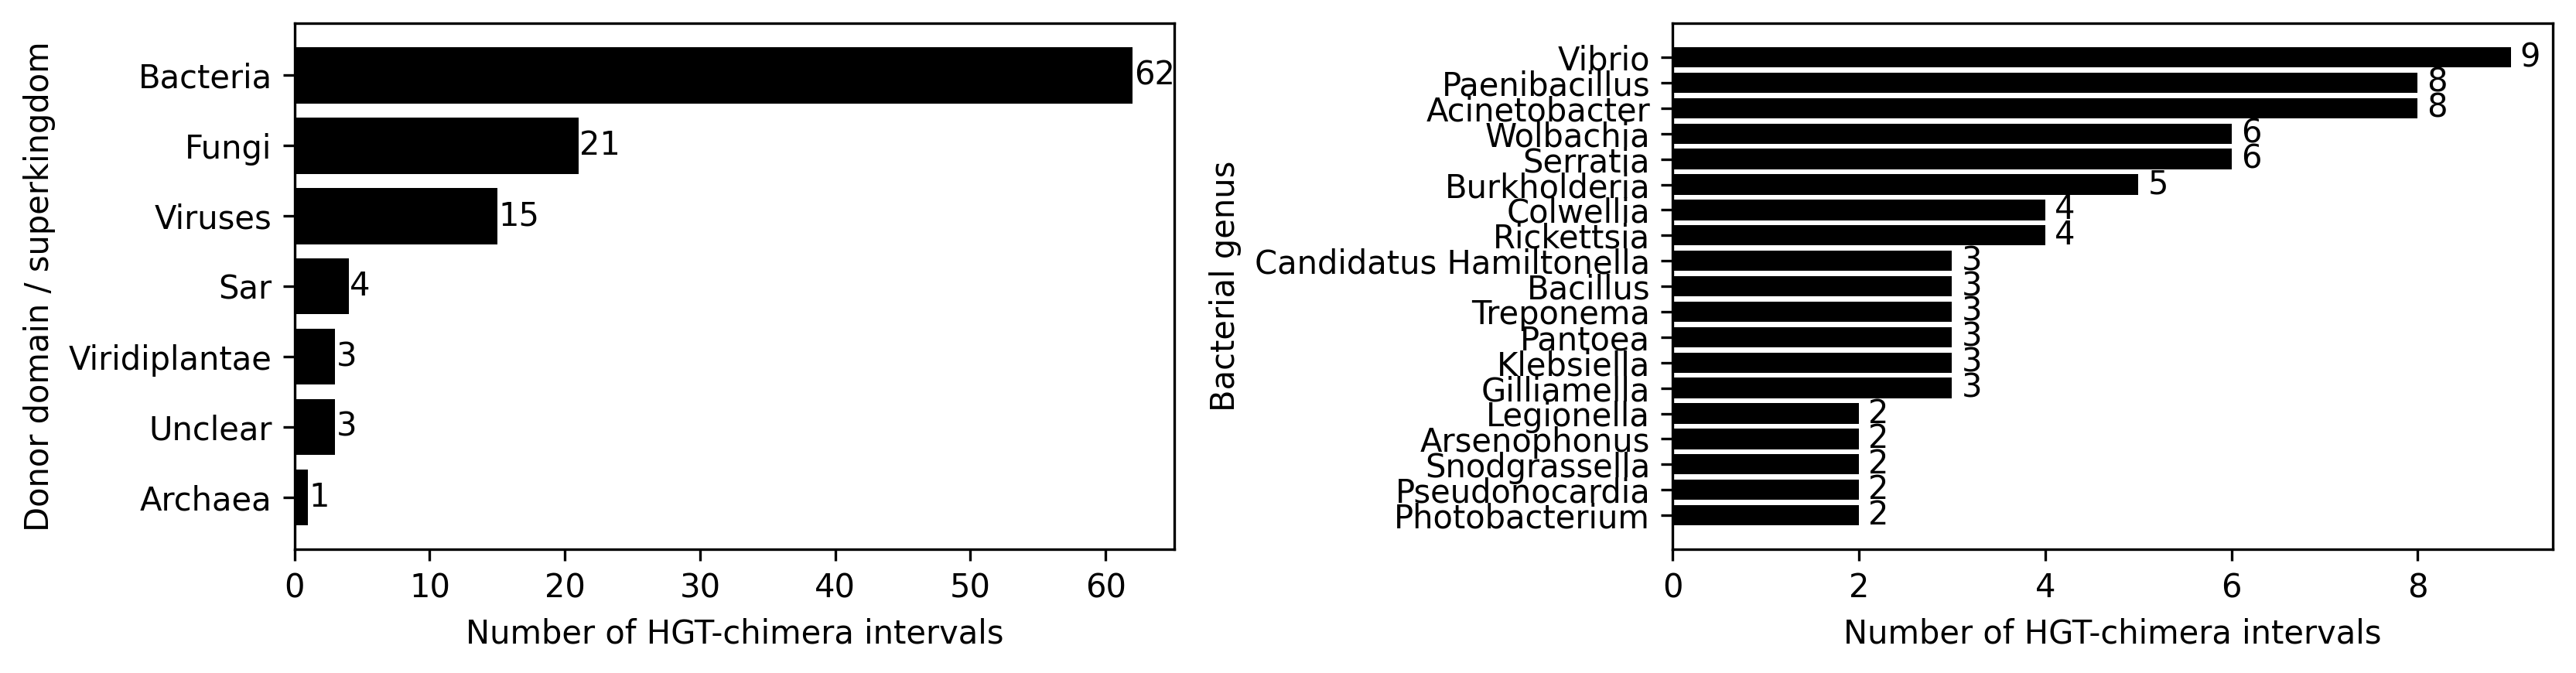

In [108]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_barh(ax, data_dict, y_label):
    """Draw a horizontal bar plot and annotate counts."""
    # Ensure the order is ascending by count (smallest at bottom)
    items = sorted(data_dict.items(), key=lambda kv: kv[1])
    labels, counts = zip(*items)

    bars = ax.barh(labels, counts, color="black")

    # Annotate each bar with its width
    for bar in bars:
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2
        ax.text(width + 0.1, y_pos, f"{width:.0f}", va="center", ha="left")

    ax.set_xlabel("Number of HGT-chimera intervals")
    ax.set_ylabel(y_label)

# ------- data preparation ----------------------------------------------------
# 1) Donor domain / superkingdom
donor_counts = dict(Counter(hgt.tree_donor))       # your first dictionary
# 2) Bacterial genus
symbio_mask = symbiodb.n_inters > 1
genus_counts = dict(zip(symbiodb[symbio_mask].index,
                        symbiodb[symbio_mask].n_inters))

# ------- plotting ------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11.2, 3),
                               sharey=False)  # set sharey=True if you want identical y-axis

plot_barh(ax1, donor_counts, "Donor domain / superkingdom")
plot_barh(ax2, genus_counts, "Bacterial genus")

plt.tight_layout()
plt.savefig("figures/Figure2_1A_1B_combined.svg", format="svg")
plt.show()


In [91]:
symbiodb[symbiodb.n_inters>1].index,symbiodb[symbiodb.n_inters>1].index

Index(['Vibrio', 'Acinetobacter', 'Paenibacillus', 'Serratia', 'Wolbachia',
       'Burkholderia', 'Rickettsia', 'Colwellia', 'Gilliamella', 'Klebsiella',
       'Pantoea', 'Treponema', 'Bacillus', 'Candidatus Hamiltonella',
       'Photobacterium', 'Pseudonocardia', 'Snodgrassella', 'Arsenophonus',
       'Legionella'],
      dtype='object', name='name')

In [96]:
symbiodb[symbiodb.n_inters>2].name,symbiodb[symbiodb.n_inters>2].name

,node,inters,n_inters
name,,,
Vibrio,662,"['GCF_002237135.1;XP_037951667.1;HGT_(1,225)',...",9.0
Acinetobacter,469,"['GCF_907165205.1;XP_044763649.1;HGT_(158,738)...",8.0
Paenibacillus,44249,"['GCF_002217175.1;XP_021965719.2;HGT_(208,419)...",8.0
Serratia,613,"['GCF_015228065.2;XP_037790819.1;HGT_(736,1165...",6.0
Wolbachia,953,"['GCF_016801865.2;XP_052565726.1;HGT_(834,1369...",6.0
Burkholderia,32008,"['GCF_002217175.1;XP_021965719.2;HGT_(208,419)...",5.0
Rickettsia,780,"['GCF_009176525.2;XP_031633908.1;HGT_(28,328)'...",4.0
Colwellia,28228,"['GCF_015228065.2;XP_037790819.1;HGT_(736,1165...",4.0
Gilliamella,1193503,"['GCF_002217175.1;XP_035708240.1;HGT_(360,547)...",3.0
